In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

In [5]:
def shift_dataframe(data):
    #The value in "shift(-x)" is the lookback period in this case 1.
    data["Target"] = data.Val.shift(-1)
    data.dropna(inplace=True)
    
    return data

In [6]:
def train_test_split(data, test_size):
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    return train, test

In [7]:
def plot_train_test(train_set, test_set):
    ax = plt.plot(train_set, label='Train set')
    ax = plt.plot(test_set, label='Test set', color = 'orange')
    
    return ax

In [8]:
def plot_ACF(data, lag):
    acfData = data.dropna()
    plot_acf(acfData, lags=lag)

In [9]:
"""
This function is partially refactored from machine learning mastery:

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
"""
def xgboost_model(train, X_test):
    train = np.asarray(train)
    #Split into X_train and y_train
    X_train, y_train = train[:,0:1], train[:, -1]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=5)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(np.asarray([X_test]))
    
    return y_pred[0]

In [10]:
"""
This walk forward validation is refactored from machine learning mastery:

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

"""

def walk_forward_validation(data, test_size):
    predictions = list()
    
    train, test = train_test_split(data, test_size)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        
        X_test, y_test = test[i, :-1], test[i, -1]
        
        y_pred = xgboost_model(history, X_test)
        
        predictions.append(y_pred)
        
    return test[:, -1], predictions

In [4]:
def performance_metrics(y_test, y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mean = np.mean(y_test)
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("R2 Score: ", r2)
    print("Mean of actual: ", mean)

In [12]:
data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'NY.GDP.PCAP.KD.ZG')


In [13]:
shifted = shift_dataframe(data)

In [14]:
finalData = shifted.values

In [15]:
finalData.dtype

dtype('float64')

In [16]:
actual, predicted = walk_forward_validation(finalData, len(data) - int(len(data) * 0.8))

RMSE:  3.6985531713823327
MAPE:  35.11203474987416
MAE:  1.594044602176267
R2 Score:  -55.05548364756093
Mean of actual:  4.070104338163304


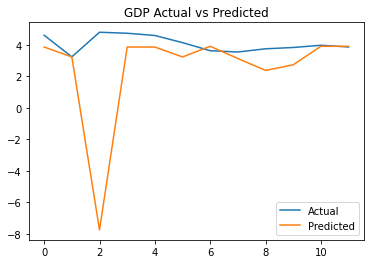

In [17]:
df_compare = pd.DataFrame({'Actual' : actual, 'Predicted' : predicted})
df_compare.plot(title='GDP Actual vs Predicted')
performance_metrics(actual, predicted)